In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
# import tensorflow as tf
from sklearn import decomposition
import cv2
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

In [3]:
LABELS =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
LABELS_TO_INDEX = {k: v for v, k in enumerate(LABELS)}
INDEX_TO_LABELS = {k: v for k, v in enumerate(LABELS)}

In [4]:
# if no dataset folder, extract it
if not os.path.exists('datasets/'):
    !unzip -q datasets.zip

In [5]:
images = []
train_labels = []
for label_name in LABELS:
    folder_path = 'datasets/HandGesture/images/' + label_name
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img.mode != 'L':
            img = img.convert('L')
        img_arr = np.array(img)
        images.append(img_arr)
        train_labels.append(label_name)
images = np.array(images)
print(images.shape)

(5243, 195, 240)


In [6]:
img_shape = images[0].shape                         # 195 x 240
X = images.reshape(images.shape[0], -1)             # flatten 195 x 240 image
y = np.vectorize(LABELS_TO_INDEX.get)(train_labels) # convert label name to index (call_me -> 0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3670, 46800)
y_train (3670,)
X_test (1573, 46800)
y_test (1573,)


# Feature Extraction using PCA

In [8]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X)
standardized_data.shape

(5243, 46800)

In [9]:
# cov_matrix = np.matmul(standardized_data.T, standardized_data)
# cov_matrix.shape

In [10]:
pca = decomposition.PCA(n_components = 2)
principal_components = pca.fit_transform(standardized_data)

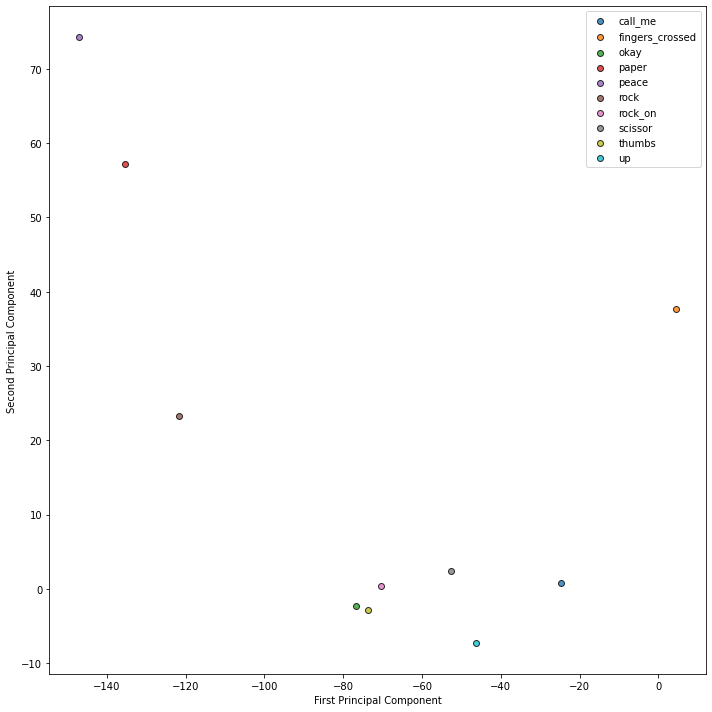

In [14]:
plt.figure(figsize=(10, 10))
labels =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

for label, color in zip(labels, colors):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], 
                c=[color], label=label, edgecolors='k', alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Feature Extration with HOG

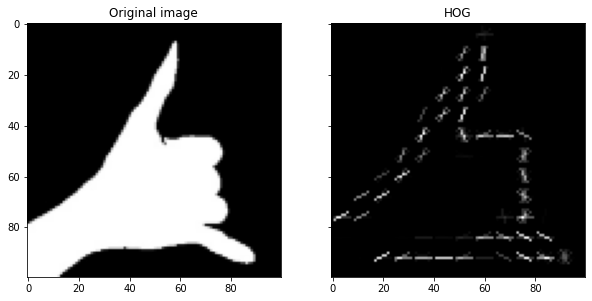

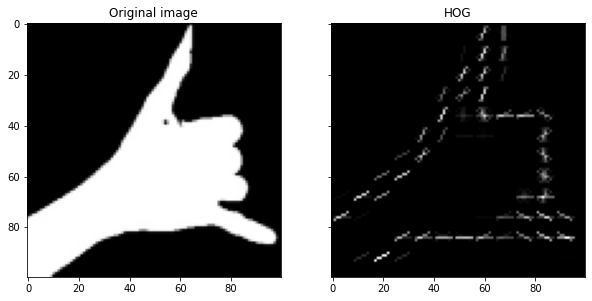

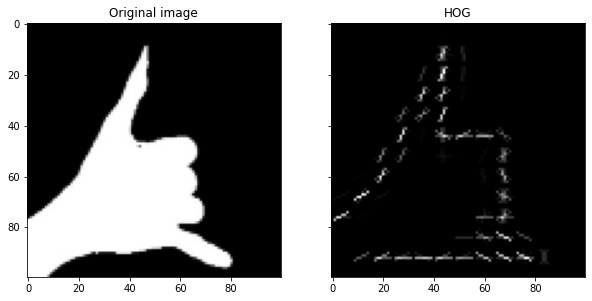

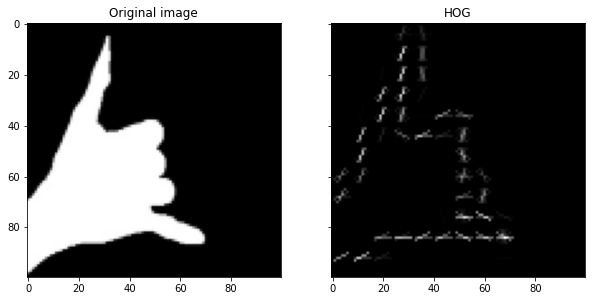

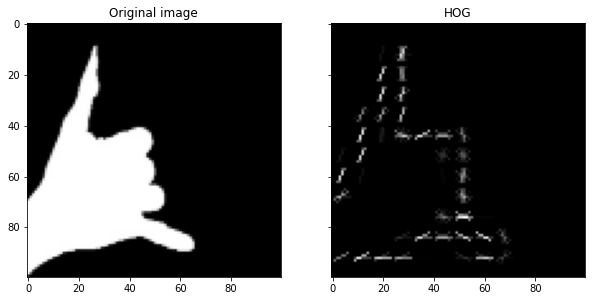

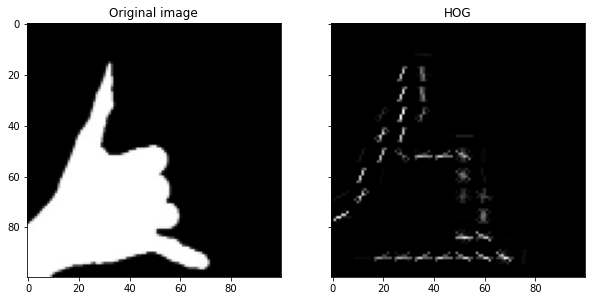

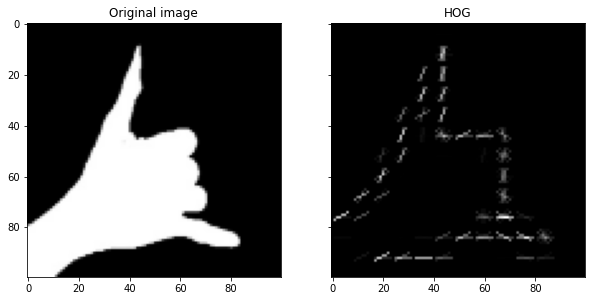

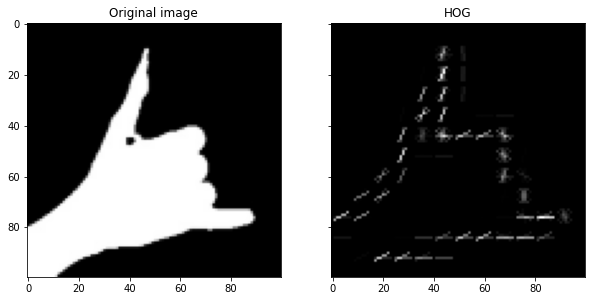

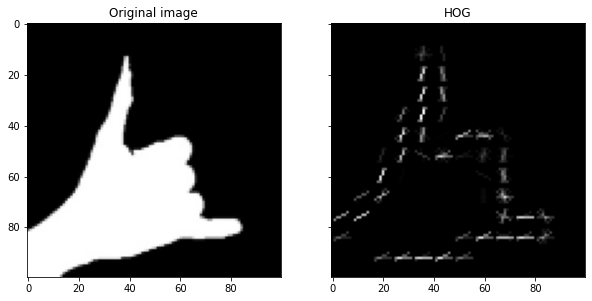

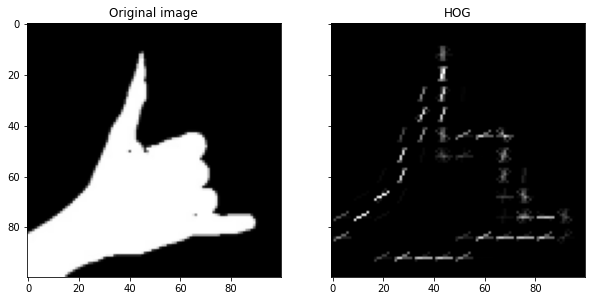

In [13]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import io


fds = []
hog_img_list = []
ori_img_list = []

max_hog_display = 10  # Display 10 HOG images, change it if different number of HOG images is desired
count = 0

for i in range(len(images)):
    img_resized = resize(images[i], (100,100)) 

    fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True)
    
    fds.append(fd)
    
    if count < max_hog_display:
        hog_img_list.append(hog_img)
        ori_img_list.append(img_resized)
    
    count +=1
    

for i in range(len(hog_img_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) 

    ax1.imshow(ori_img_list[i], cmap=plt.cm.gray) 
    ax1.set_title('Original image') 

    # Rescale histogram
    hog_image_rescaled = exposure.rescale_intensity(hog_img_list[i], in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('HOG')

    plt.show()

# Classification Using K-Means

In [ ]:
img = images[0] # warning: this is a uint8
plt.imshow(img, cmap=plt.cm.gray)

from sklearn.cluster import KMeans, MiniBatchKMeans

# Perform K Means
K = 100 # begin with 10 (number of gesture labels), increase to much much more as necessary
kmeans = MiniBatchKMeans(n_clusters = K)
kmeans.fit(X_train)

In [ ]:
print(kmeans.labels_) # cluster labels for each training image
print(kmeans.cluster_centers_.shape) # K clusters x 46800 pixels

def visualize_all_clusters(kmeans):
    for i in range(len(kmeans.cluster_centers_)):
        center = kmeans.cluster_centers_[i].reshape((img_shape))
        plt.imshow(center)
        plt.show()

# for each KMeans cluster, get the most probable label
# return mapping from cluster to label
def cluster_to_index(cluster_labels, y_train):
    index_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        index_labels[i] = num
    return index_labels

CLUSTERS_TO_INDEX = cluster_to_index(kmeans.labels_, y_train)
print(CLUSTERS_TO_INDEX)

In [ ]:
# Get test results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cluster_ids = kmeans.predict(X_test)
y_pred = np.vectorize(CLUSTERS_TO_INDEX.get)(cluster_ids)

print('Accuracy:',  accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:',    recall_score(y_test, y_pred, average='micro'))
print('F1:',        f1_score(y_test, y_pred, average='micro'))

In [ ]:
# take 10 test images, predict them, and display them
N = 10
fig, axs = plt.subplots(N, 2, sharex='all', sharey='all', figsize=(10, 10*N))

imgs = X_test[:N]
cluster_ids = kmeans.predict(imgs) # cluster index

for i in range(N):
    img = imgs[i]
    cluster_id = cluster_ids[i]
    cluster = kmeans.cluster_centers_[cluster_id].reshape((img_shape)) # cluster image

    true_label = INDEX_TO_LABELS[y_test[i]]
    pred_label = INDEX_TO_LABELS[CLUSTERS_TO_INDEX[cluster_id]]

    axs[i, 0].imshow(cluster, cmap=plt.cm.gray)
    axs[i, 0].set_title('Prediction: {}'.format(pred_label))

    axs[i, 1].imshow(img.reshape((img_shape)), cmap=plt.cm.gray)
    axs[i, 1].set_title('Actual: {}'.format(true_label))

# Classification using Hidden Markov Model 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.3, random_state=0)

In [28]:
labels =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']

In [40]:
def separate_data_by_labels(x, y):
    separated_data = {}
    for i, label in enumerate(y):
        if label not in separated_data:
            separated_data[label] = []
        separated_data[label].append(x[i])
    
    # Convert lists to numpy arrays
    for label in separated_data:
        separated_data[label] = np.array(separated_data[label])
    
    return separated_data

In [41]:
train_separate = separate_data_by_labels(X_train, y_train)

In [45]:
n_hidden_states = 3
models = {}
for label, data_points in train_separate.items():
    model = hmm.GaussianHMM(n_components=n_hidden_states, covariance_type="diag")
    model.fit(data_points)
    models[label] = model


MemoryError: Unable to allocate 16.3 GiB for an array with shape (46800, 46800) and data type float64

In [31]:
X_train[y_train == 'rock']

array([], shape=(0, 3670, 46800), dtype=uint8)

In [33]:
X_train.shape

(3670, 46800)

In [35]:
X_train[1].shape

(46800,)

In [38]:
y_train == 'rock'

False